# Autoencoding
<br>An autoencoder is a neural network that:
- Compresses data into a smaller representation (encoding)
- Reconstructs the original data from this compressed form (decoding)
- Learns to do this without any labels or supervision (unsupervised)

Here, the autoencoder aims to identify unusual patterns in the transactions.
<br>It tries to reconstruct all transactions, but:
- Common patterns are easier to reconstruct
- Unusual patterns are harder to reconstruct

## Setup and Imports

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Data Visualization
plt.style.use('seaborn-v0_8')

## Data Loading

In [2]:
features_df = pd.read_csv('../raw_data/elliptic_txs_features.csv', header=None)
classes_df = pd.read_csv('../raw_data/elliptic_txs_classes.csv')

In [3]:
features_df.columns = ['txId'] + [f'feature_{i}' for i in range(1, len(features_df.columns))]

In [4]:
df = pd.merge(features_df, classes_df, on='txId')

Let's drop 'txId' as it's not a feature that we need for our autoencoding model:

In [5]:
df = df.drop('txId', axis=1)

Now let's separate X (features) and y (labels), and only use X as our input data:

In [6]:
X = df.drop('class', axis=1)
y = df['class']

## Preprocessing

In our autoencoder implementation, we're not using the labels (Class 1, 2, unknown) because:
<br>- Autoencoders are unsupervised learning models
<br>- They learn to reconstruct the input data
<br>- They don't require knowledge of the transaction class
<br>Data is standardized using StandardScaler

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2,
    random_state=42
)

Store the total number of features (166) inside input_dim
<br>and define the smallest compression value:

In [10]:
input_dim = X_scaled.shape[1]
encoding_dim = 32

Define the number of neurons in each layer:

In [11]:
hidden_dims = [128, 64, encoding_dim, 64, 128]

Gradually compress the data down to encoding_dim and back to its original form:

In [12]:
# Initialize the autoencoder
autoencoder = MLPRegressor(
    hidden_layer_sizes=hidden_dims,
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=100,
    random_state=42
)

We use the same input/output data (X_scaled) since we want the output to match the input:

In [13]:
# Train the model
autoencoder.fit(X_scaled, X_scaled)

/Users/alicepicot/code/alicezoe/elliptic_insight/elliptic-insight/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"[128, 64, ...]"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,100
,shuffle,True


## Data Visualization

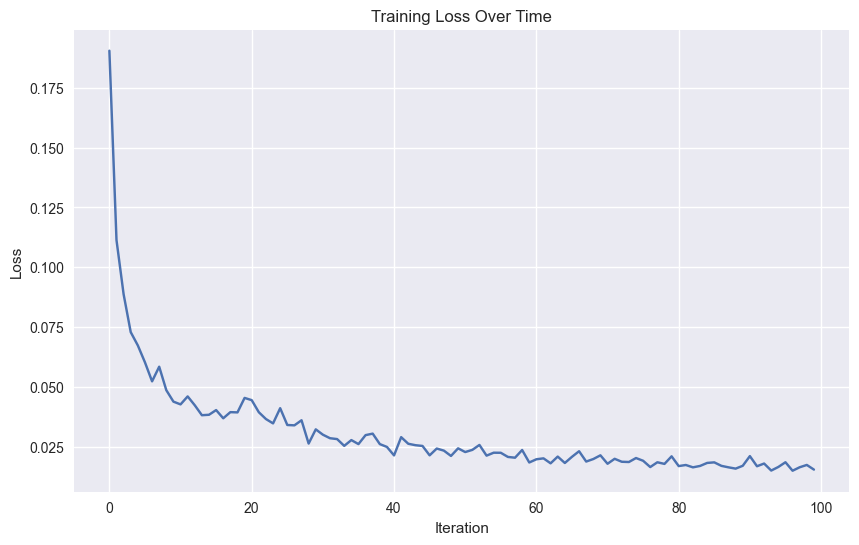

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(autoencoder.loss_curve_)
plt.title('Training Loss Over Time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [25]:
print(f"Input dimension: {input_dim}")
print(f"Hidden layer sizes: {hidden_dims}")
print(f"Final loss: {autoencoder.loss_:.4f}")

Input dimension: 166
Hidden layer sizes: [128, 64, 32, 64, 128]
Final loss: 0.0154


Our final loss result is quite good. (Perfect reconstruction would be 0)


The reconstructed data is what the model thinks the input should look like after compressing and decompressing it

In [26]:
# Get reconstructions and calculate errors
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean((X_scaled - reconstructions) ** 2, axis=1)
anomalies = reconstruction_errors > 0.8

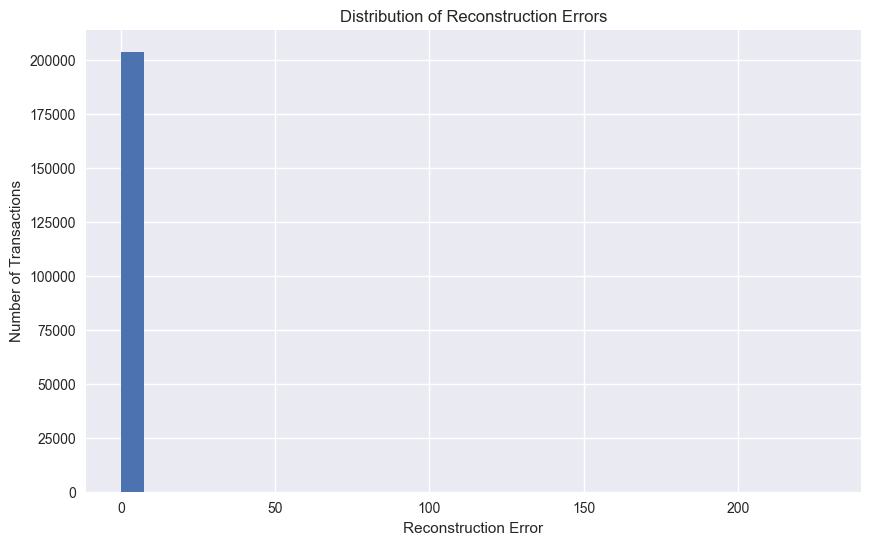

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=30)
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Transactions')
plt.show()

In [28]:
print(f"Mean reconstruction error: {np.mean(reconstruction_errors):.4f}")
print(f"Min reconstruction error: {np.min(reconstruction_errors):.4f}")
print(f"Max reconstruction error: {np.max(reconstruction_errors):.4f}")
print(f"Standard deviation of reconstruction errors: {np.std(reconstruction_errors):.4f}")

Mean reconstruction error: 0.0323
Min reconstruction error: 0.0011
Max reconstruction error: 228.4483
Standard deviation of reconstruction errors: 0.8048


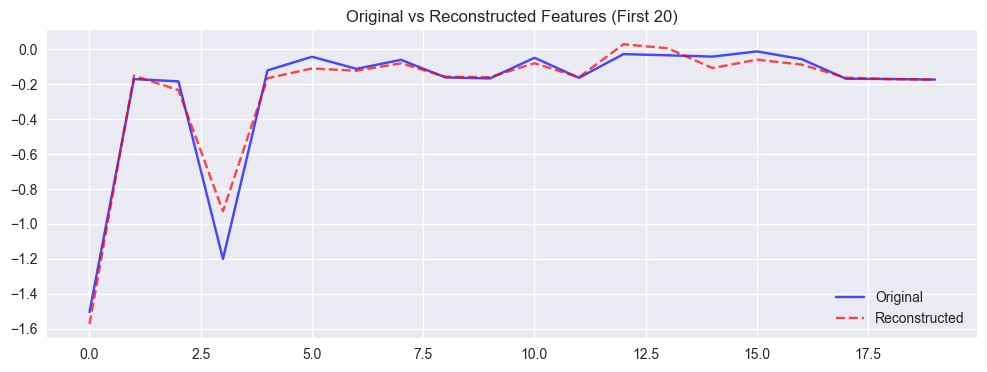

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(X_scaled[0][:20], 'b-', label='Original', alpha=0.7)
plt.plot(reconstructions[0][:20], 'r--', label='Reconstructed', alpha=0.7)
plt.title('Original vs Reconstructed Features (First 20)')
plt.grid(True)
plt.legend()
plt.show()

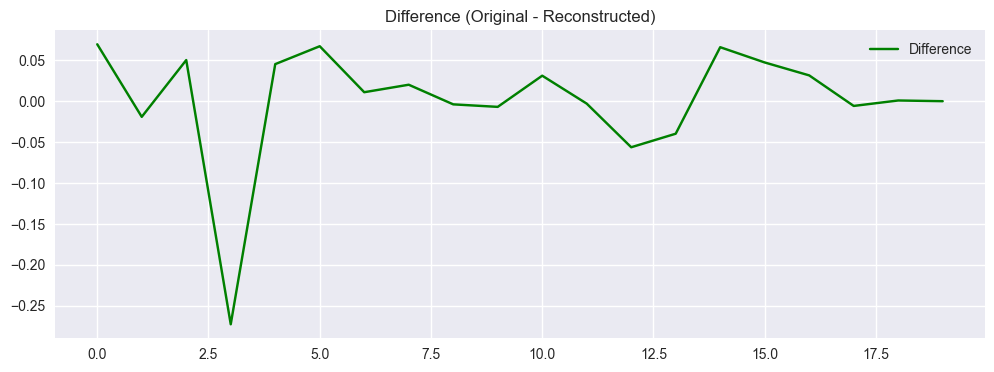

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(X_scaled[0][:20] - reconstructions[0][:20], 'g-', label='Difference')
plt.title('Difference (Original - Reconstructed)')
plt.grid(True)
plt.legend()
plt.show()

By looking at the first 20 features of a single transaction, we can see that our autoencoder performs pretty well, and is able to reconstruct the input data.

However, we can see a spike around the 3rd feature.

Let's look into it:

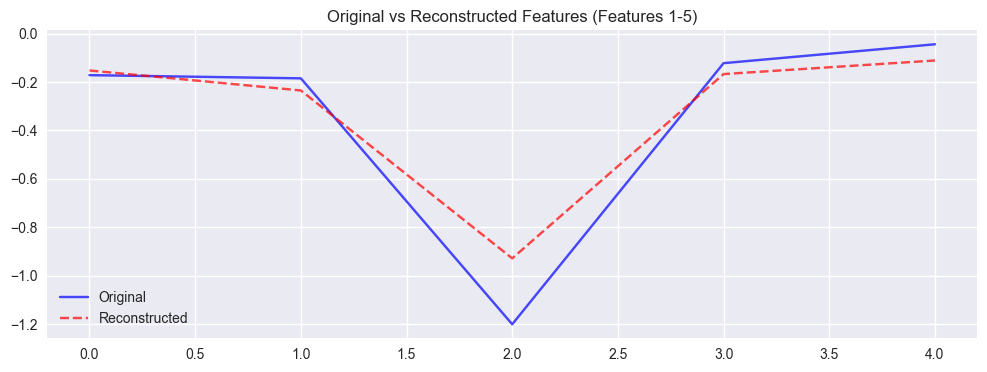

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(X_scaled[0][1:6], 'b-', label='Original', alpha=0.7)
plt.plot(reconstructions[0][1:6], 'r--', label='Reconstructed', alpha=0.7)
plt.title('Original vs Reconstructed Features (Features 1-5)')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
print("Original values (features 1-5):")
print(X_scaled[0][1:6])
print("\nReconstructed values (features 1-5):")
print(reconstructions[0][1:6])
print("\nDifferences (features 1-5):")
print(X_scaled[0][1:6] - reconstructions[0][1:6])

Original values (features 1-5):
[-0.17146929 -0.18466755 -1.2013688  -0.1219696  -0.04387455]

Reconstructed values (features 1-5):
[-0.15220253 -0.23476027 -0.92876923 -0.167085   -0.11086357]

Differences (features 1-5):
[-0.01926676  0.05009272 -0.27259958  0.0451154   0.06698902]


So far, we trained our model on all transactions (licit, illicit and unknown)

Let's use only the licit transactions, so that our model learns the patterns of licit transactions.
Hopefully, when it sees an illicit transaction it will show a higher reconstruction error.

First, let's filter for licit transactions:

In [53]:
licit_tx = df.loc[df['class'] == '2']

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,class
3,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,...,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
9,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,-0.144554,...,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792,2
10,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,-0.144108,...,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
11,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,-0.147643,...,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
16,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,-0.169115,...,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203740,49,-0.133841,-0.109114,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.123596,-0.129972,...,1.467840,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
203750,49,-0.172455,-0.138626,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163104,-0.168926,...,-0.569462,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,2
203752,49,-0.159293,-0.037276,1.018602,-0.121970,0.035526,-0.113002,-0.061584,-0.149635,-0.155646,...,1.408971,0.231244,-0.388216,-0.098889,1.931078,3.168259,3.707301,-1.390548,-1.214035,2
203754,49,-0.172962,-0.126566,1.018602,-0.121970,-0.063725,-0.113002,-0.061584,-0.163622,-0.169437,...,0.647874,0.241128,0.241406,10.914916,1.700384,-0.131155,7.914145,-0.120613,-0.119792,2


Then, we drop the 'class' column for X to only get the features, <br>and y keeps only the 'class' column:

In [54]:
X_licit = licit_tx.drop('class', axis=1)
y_licit = licit_tx['class']

In [75]:
df['class'].value_counts()

class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64

In [76]:
len(X_licit)

42019

In [57]:
scaler = StandardScaler()
X_licit_scaled = scaler.fit_transform(X_licit)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_licit_scaled, y_licit, 
    test_size=0.2,
    random_state=42
)

In [59]:
input_dim = X_licit_scaled.shape[1]
encoding_dim = 32
hidden_dims = [128, 64, encoding_dim, 64, 128]

In [60]:
autoencoder = MLPRegressor(
    hidden_layer_sizes=hidden_dims,
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=100,
    random_state=42
)

In [61]:
autoencoder.fit(X_licit_scaled, X_licit_scaled)

/Users/alicepicot/code/alicezoe/elliptic_insight/elliptic-insight/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"[128, 64, ...]"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'adaptive'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,100
,shuffle,True


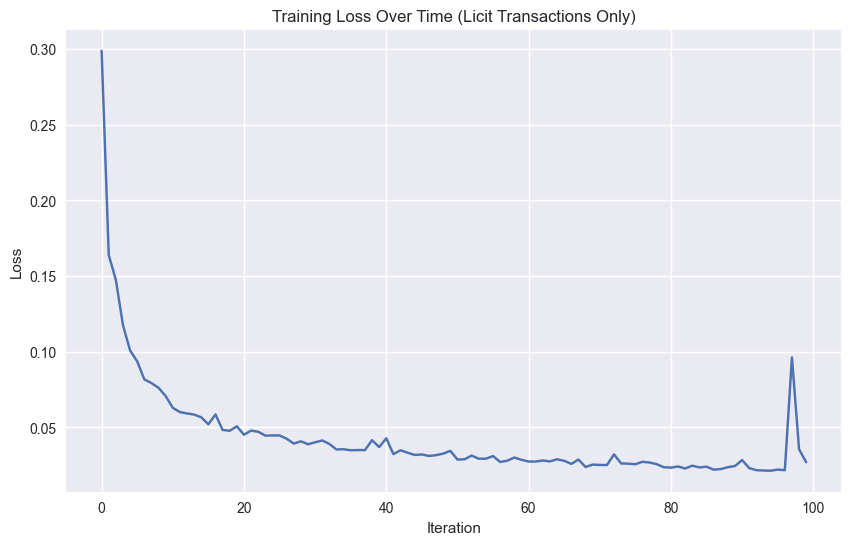

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(autoencoder.loss_curve_)
plt.title('Training Loss Over Time (Licit Transactions Only)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Now, let's test our model on all transactions:

In [71]:
X_all_scaled = scaler.transform(X)
reconstructions = autoencoder.predict(X_all_scaled)
reconstruction_errors = np.mean((X_all_scaled - reconstructions) ** 2, axis=1)

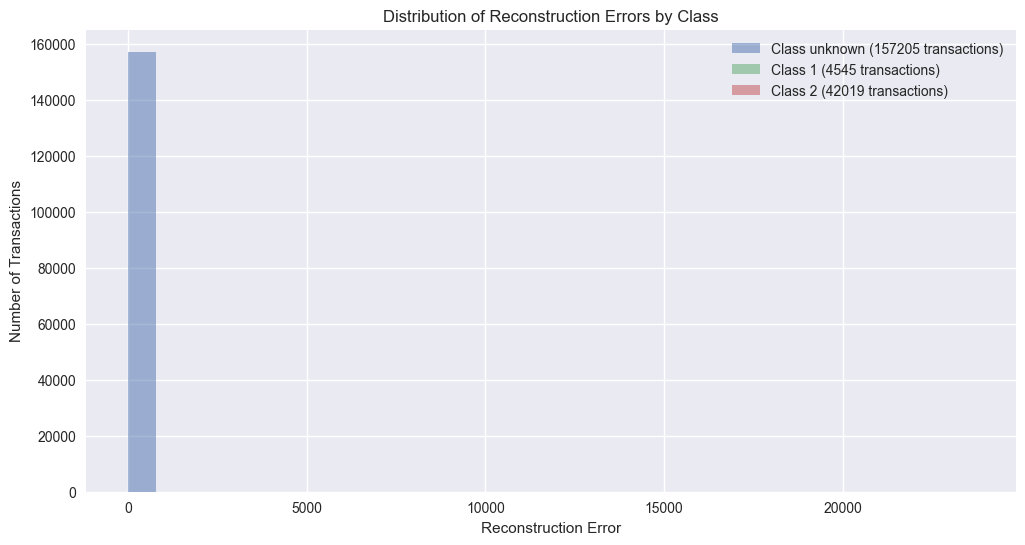

In [79]:
plt.figure(figsize=(12, 6))
for class_label in ['unknown', '1', '2']:
    class_data = df.loc[df['class'] == class_label]
    class_errors = reconstruction_errors[class_data.index]
    
    plt.hist(class_errors, bins=30, alpha=0.5, 
             label=f'Class {class_label} ({len(class_data)} transactions)')
plt.title('Distribution of Reconstruction Errors by Class')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()

In [81]:
for class_label in ['unknown', '1', '2']:
    mask = (df['class'] == class_label)
    class_errors = reconstruction_errors[mask]
    print(f"\nClass {class_label}:")
    print(f"Mean error: {np.mean(class_errors):.4f}")
    print(f"Min error: {np.min(class_errors):.4f}")
    print(f"Max error: {np.max(class_errors):.4f}")
    print(f"Std error: {np.std(class_errors):.4f}")


Class unknown:
Mean error: 2.1987
Min error: 0.0019
Max error: 23659.6465
Std error: 187.7632

Class 1:
Mean error: 0.0235
Min error: 0.0025
Max error: 2.5410
Std error: 0.0635

Class 2:
Mean error: 0.0461
Min error: 0.0021
Max error: 33.3953
Std error: 0.2549


In [88]:
transaction_idx = 123

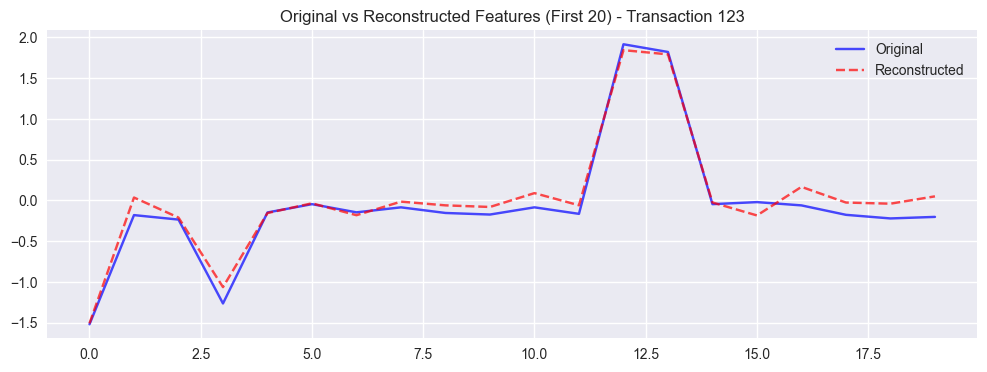

In [89]:
plt.figure(figsize=(12, 4))
plt.plot(X_all_scaled[transaction_idx][:20], 'b-', label='Original', alpha=0.7)
plt.plot(reconstructions[transaction_idx][:20], 'r--', label='Reconstructed', alpha=0.7)
plt.title(f'Original vs Reconstructed Features (First 20) - Transaction {transaction_idx}')
plt.grid(True)
plt.legend()
plt.show()